In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import get_connection
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

import prepare as p
import acquire as a
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [2]:
majorcity_df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

In [3]:
majorcity_df.head(1)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [4]:
majorcity_df = majorcity_df.dropna()

In [5]:
majorcity_df.head(3)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [6]:
majorcity_df = p.majorcity_organize(majorcity_df)

In [7]:
majorcity_df

,avg_temp,avg_uncert,city,country,lat,long
dt,,,,,,
1743-11-01,7.541,1.753,London,United Kingdom,52.24N,0.00W
1743-11-01,0.895,2.092,Kiev,Ukraine,50.63N,31.69E
1743-11-01,-1.854,1.734,Montreal,Canada,45.81N,72.69W
1743-11-01,-2.570,2.037,Moscow,Russia,55.45N,36.85E
1743-11-01,10.365,2.325,Istanbul,Turkey,40.99N,29.82E
...,...,...,...,...,...,...
2013-09-01,17.408,1.048,New York,United States,40.99N,74.56W
2013-09-01,23.301,0.984,Los Angeles,United States,34.56N,118.70W
2013-09-01,14.599,1.274,Toronto,Canada,44.20N,80.50W


In [8]:
chicago_df = majorcity_df[majorcity_df.city == 'Chicago']

In [9]:
chicago_df.head()

,avg_temp,avg_uncert,city,country,lat,long
dt,,,,,,
1743-11-01,5.436,2.205,Chicago,United States,42.59N,87.27W
1744-04-01,8.766,2.357,Chicago,United States,42.59N,87.27W
1744-05-01,11.605,2.102,Chicago,United States,42.59N,87.27W
1744-06-01,17.965,1.989,Chicago,United States,42.59N,87.27W
1744-07-01,21.680,1.786,Chicago,United States,42.59N,87.27W


In [10]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3141 entries, 1743-11-01 to 2013-09-01
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   avg_temp    3141 non-null   float64
 1   avg_uncert  3141 non-null   float64
 2   city        3141 non-null   object 
 3   country     3141 non-null   object 
 4   lat         3141 non-null   object 
 5   long        3141 non-null   object 
dtypes: float64(2), object(4)
memory usage: 171.8+ KB


### <center>I noticed the temperatures were in Celcius, but since this is America, I'm going to convert it to Fahrenheit

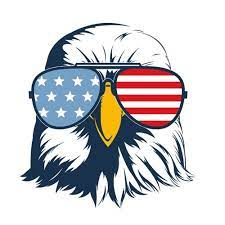

In [11]:
chicago_df = p.this_is_america(chicago_df)

In [12]:
chicago_df.index.min()

Timestamp('1743-11-01 00:00:00')

In [13]:
chicago_df.index.max()

Timestamp('2013-09-01 00:00:00')

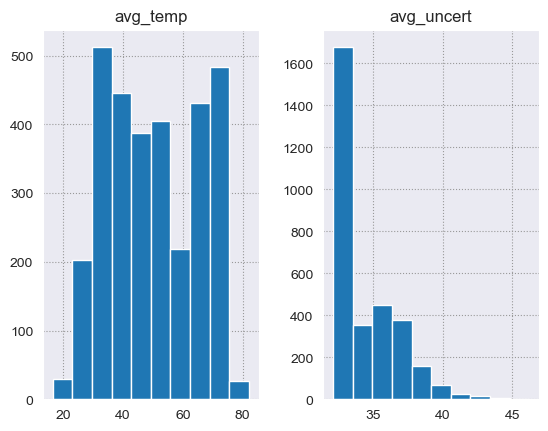

In [14]:
p.distributions(chicago_df)

In [15]:
chicago_df

,avg_temp,avg_uncert,city,country,lat,long
dt,,,,,,
1743-11-01,41.7848,35.9690,Chicago,United States,42.59N,87.27W
1744-04-01,47.7788,36.2426,Chicago,United States,42.59N,87.27W
1744-05-01,52.8890,35.7836,Chicago,United States,42.59N,87.27W
1744-06-01,64.3370,35.5802,Chicago,United States,42.59N,87.27W
1744-07-01,71.0240,35.2148,Chicago,United States,42.59N,87.27W
...,...,...,...,...,...,...
2013-05-01,56.7212,33.5534,Chicago,United States,42.59N,87.27W
2013-06-01,64.2434,33.2042,Chicago,United States,42.59N,87.27W
2013-07-01,71.4452,32.5796,Chicago,United States,42.59N,87.27W


In [16]:
chicago_resampled = chicago_df.resample('Y')[['avg_temp', 'avg_uncert']].mean()

In [17]:
chicago_resampled['avg_temp'] = chicago_resampled['avg_temp'].bfill()

In [18]:
chicago_resampled['avg_uncert'] = chicago_resampled['avg_uncert'].bfill()

In [19]:
#chicago_resampled = chicago_resampled.dropna()

Text(0.5, 1.0, 'Average Temperature\nby Year')

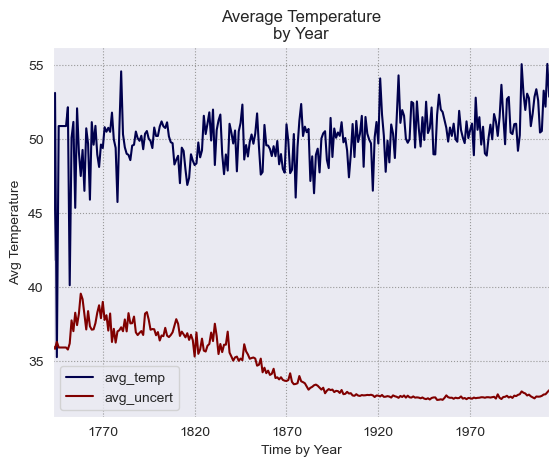

In [20]:
chicago_resampled.plot(colormap = 'seismic')
plt.ylabel('Avg Temperature')
plt.xlabel('Time by Year')
plt.title('Average Temperature\nby Year')

What this tells me is that as time went on and technology and the ability to more accurately predict weather got better, the uncertainty minimized a great deal

In [21]:
train_size = int(round(chicago_resampled.shape[0] * 0.5))
train_size

136

In [22]:
validate_size = int(chicago_resampled.shape[0] * 0.3)
validate_size

81

In [23]:
test_size = int(chicago_resampled.shape[0] * 0.2)
test_size

54

In [24]:
len(chicago_resampled) == train_size + validate_size + test_size

True

In [25]:
validate_end_index = train_size + validate_size
validate_end_index

217

In [26]:
train = chicago_resampled[:train_size]

In [27]:
train.tail()

,avg_temp,avg_uncert
dt,,
1874-12-31,50.33210,33.40370
1875-12-31,46.03385,33.42140
1876-12-31,49.43615,33.47000
1877-12-31,51.22175,33.95705
1878-12-31,52.36580,33.60170


In [28]:
validate = chicago_resampled[train_size:validate_end_index]

In [29]:
validate.head()

,avg_temp,avg_uncert
dt,,
1879-12-31,50.20085,33.54350
1880-12-31,50.83310,33.46775
1881-12-31,50.45720,33.25640
1882-12-31,50.67935,33.03410
1883-12-31,47.15795,33.15905


In [30]:
test = chicago_resampled[validate_end_index:]

In [31]:
test.head()

,avg_temp,avg_uncert
dt,,
1960-12-31,50.20310,32.49200
1961-12-31,51.03515,32.41940
1962-12-31,49.98785,32.49230
1963-12-31,49.81040,32.45855
1964-12-31,51.90350,32.46980


In [32]:
train.shape[0], validate.shape[0], test.shape[0]


(136, 81, 54)

In [33]:
print(chicago_resampled.head(1) == train.head(1))


            avg_temp  avg_uncert
dt                              
1743-12-31      True        True


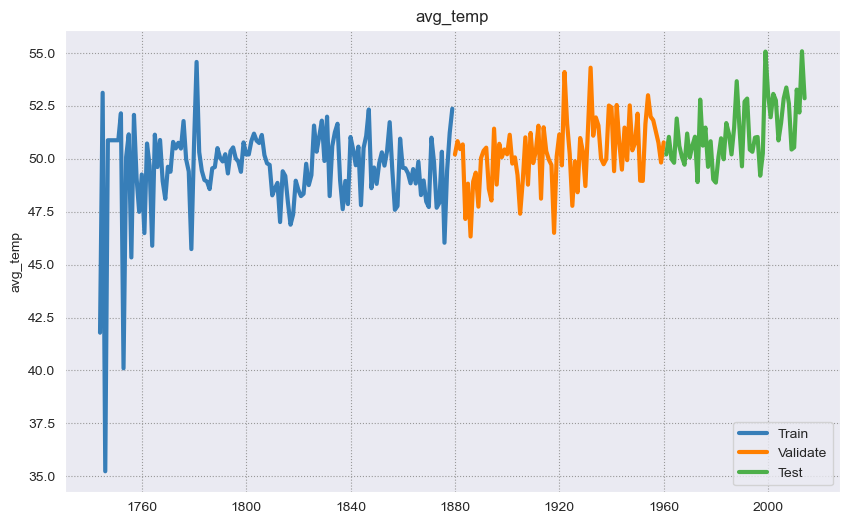

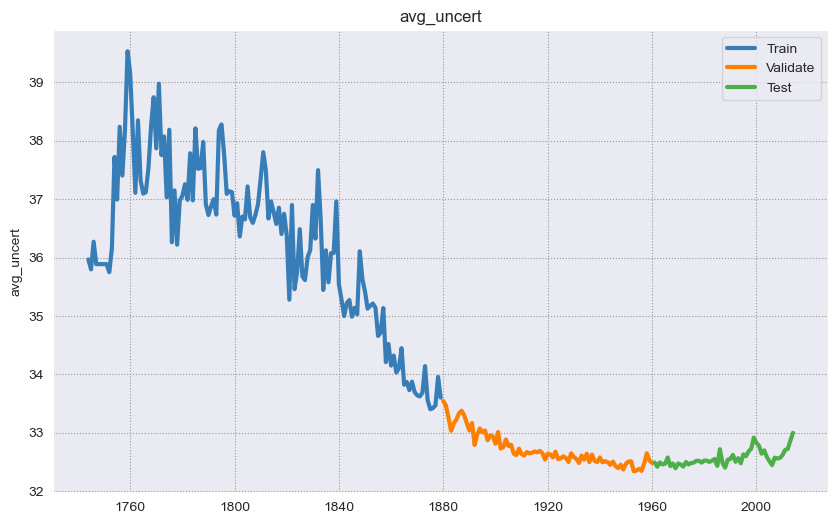

In [34]:
for col in train.columns:
    plt.figure(figsize=(10,6))
    plt.plot(train[col], color = '#377eb8', label = 'Train', linewidth = 3)
    plt.plot(validate[col], color = '#ff7f00', label = 'Validate', linewidth = 3)
    plt.plot(test[col], color = '#4daf4a', label = 'Test', linewidth = 3)
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

<AxesSubplot:>

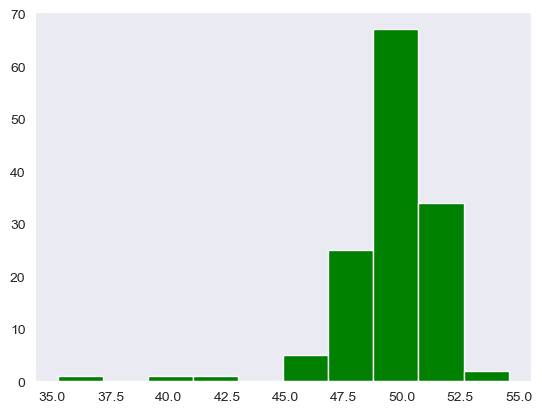

In [35]:
train.avg_temp.hist(color = 'green', grid = False)

In [36]:
train['year'] = train.index.strftime('%Y')
train['year'] = train.year.astype(int)

In [37]:
train.head()

,avg_temp,avg_uncert,year
dt,,,
1743-12-31,41.784800,35.969000,1743
1744-12-31,53.117375,35.798000,1744
1745-12-31,35.238200,36.271850,1745
1746-12-31,50.874636,35.888327,1746
1747-12-31,50.874636,35.888327,1747


In [38]:
decades = pd.cut(train.year, 27)

<AxesSubplot:xlabel='dt'>

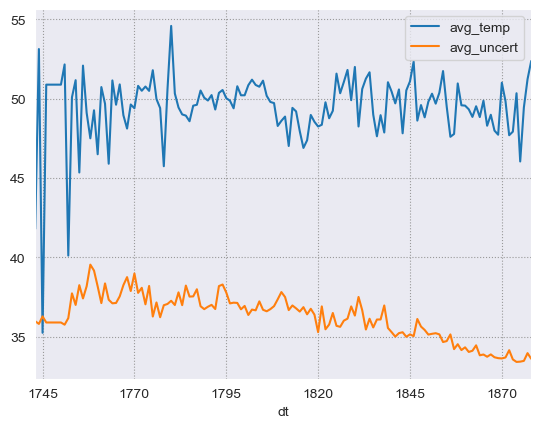

In [39]:
train = train.drop(columns = 'year')
train.plot()

<AxesSubplot:xlabel='dt'>

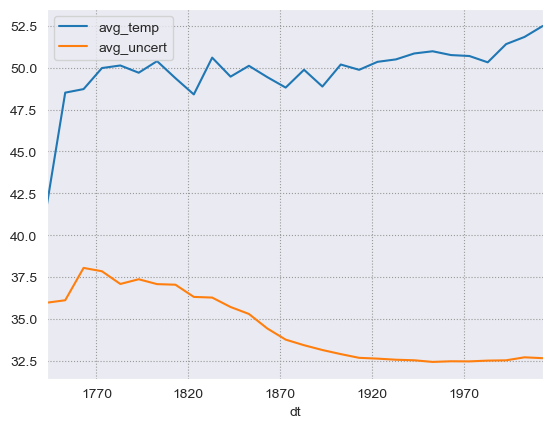

In [40]:
chicago_resampled.resample('10Y').mean().plot()

In [41]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = sqrt(mean_squared_error(validate[target_var], yhat_df[target_var]))
    return rmse

In [42]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='chartreuse')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='royalblue')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='orangered')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [43]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [44]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [45]:
train['avg_temp'][-1:][0]

52.3658

In [46]:
last_temp = train['avg_temp'][-1:][0]

In [47]:
last_uncert = train['avg_uncert'][-1:][0]
last_uncert

33.6017

In [48]:
yhat_df = pd.DataFrame(
    {'avg_temp': [last_temp],
     'avg_uncert': [last_uncert]},
    index=validate.index)

yhat_df.head()

,avg_temp,avg_uncert
dt,,
1879-12-31,52.3658,33.6017
1880-12-31,52.3658,33.6017
1881-12-31,52.3658,33.6017
1882-12-31,52.3658,33.6017
1883-12-31,52.3658,33.6017


In [49]:
yhat_df.describe()

,avg_temp,avg_uncert
count,8.100000e+01,8.100000e+01
mean,5.236580e+01,3.360170e+01
std,2.144910e-14,2.859879e-14
min,5.236580e+01,3.360170e+01
25%,5.236580e+01,3.360170e+01
50%,5.236580e+01,3.360170e+01
75%,5.236580e+01,3.360170e+01
max,5.236580e+01,3.360170e+01


avg_temp -- RMSE: 3


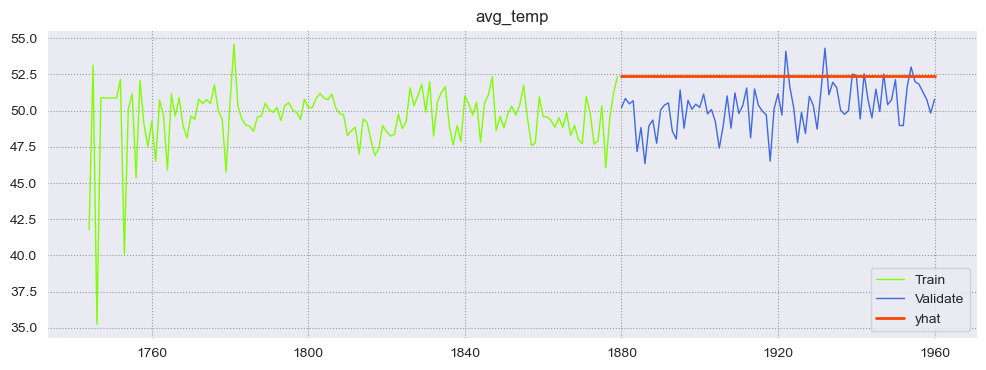

avg_uncert -- RMSE: 1


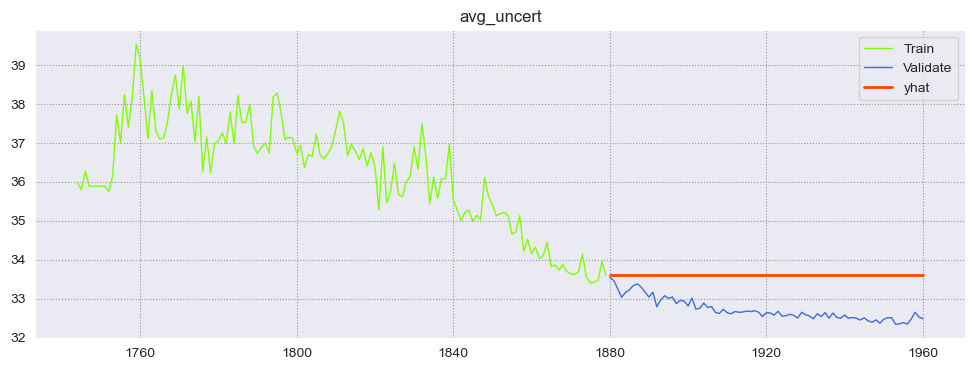

In [50]:
for col in train.columns:
    plot_and_eval(col)

In [51]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,2.592523
1,last_observed_value,avg_uncert,0.927484


In [52]:
avg_ovl_temp = train['avg_temp'].mean()
avg_ovl_temp

49.46319526737967

In [53]:
avg_ovl_uncert = train['avg_uncert'].mean()
avg_ovl_uncert

36.2321154278075

In [54]:
def make_baseline_predictions(temp_predictions=None, uncert_predictions=None):
    yhat_df = pd.DataFrame({'avg_temp': [temp_predictions],
                           'avg_uncert': [uncert_predictions]},
                          index=validate.index)
    return yhat_df

In [55]:
yhat_df = make_baseline_predictions(avg_ovl_temp, avg_ovl_uncert)

In [56]:
yhat_df.head()

,avg_temp,avg_uncert
dt,,
1879-12-31,49.463195,36.232115
1880-12-31,49.463195,36.232115
1881-12-31,49.463195,36.232115
1882-12-31,49.463195,36.232115
1883-12-31,49.463195,36.232115


avg_temp -- RMSE: 2


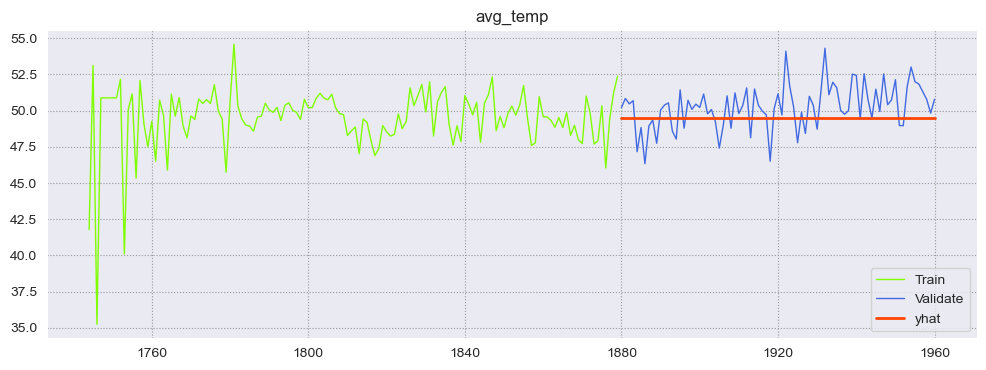

avg_uncert -- RMSE: 4


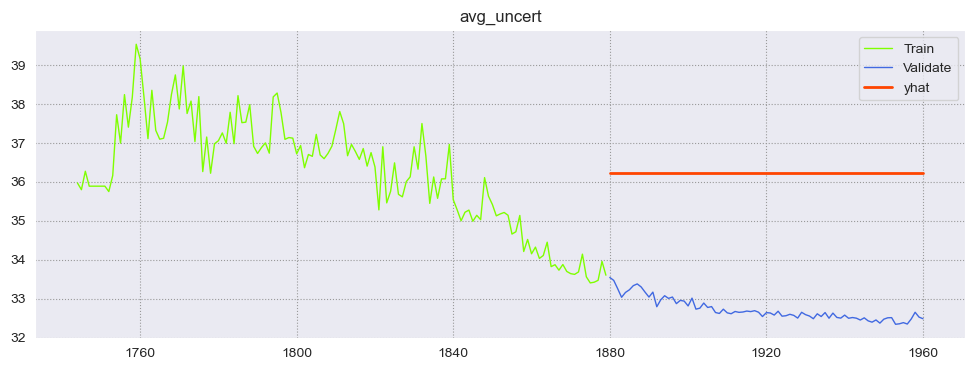

In [57]:
for col in train.columns:
    plot_and_eval(col)

In [58]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,2.592523
1,last_observed_value,avg_uncert,0.927484
2,simple_average,avg_temp,1.720254
3,simple_average,avg_uncert,3.525350


# Moving Average

In [59]:
period=10
train['avg_temp'].rolling(period).mean()

dt
1743-12-31          NaN
1744-12-31          NaN
1745-12-31          NaN
1746-12-31          NaN
1747-12-31          NaN
                ...    
1874-12-31    48.958385
1875-12-31    48.575495
1876-12-31    48.690560
1877-12-31    48.915095
1878-12-31    49.353755
Freq: A-DEC, Name: avg_temp, Length: 136, dtype: float64

In [60]:
period=10
train['avg_temp'].rolling(period).mean()[-1]

49.353755

In [61]:
rolling_temp_avg = train['avg_temp'].rolling(period).mean()[-1]
rolling_uncert_avg = train['avg_uncert'].rolling(period).mean()[-1]
print(rolling_temp_avg, rolling_uncert_avg)

49.353755 33.65051


In [62]:
yhat_df = make_baseline_predictions(rolling_temp_avg, rolling_uncert_avg)
yhat_df.head()

,avg_temp,avg_uncert
dt,,
1879-12-31,49.353755,33.65051
1880-12-31,49.353755,33.65051
1881-12-31,49.353755,33.65051
1882-12-31,49.353755,33.65051
1883-12-31,49.353755,33.65051


avg_temp -- RMSE: 2


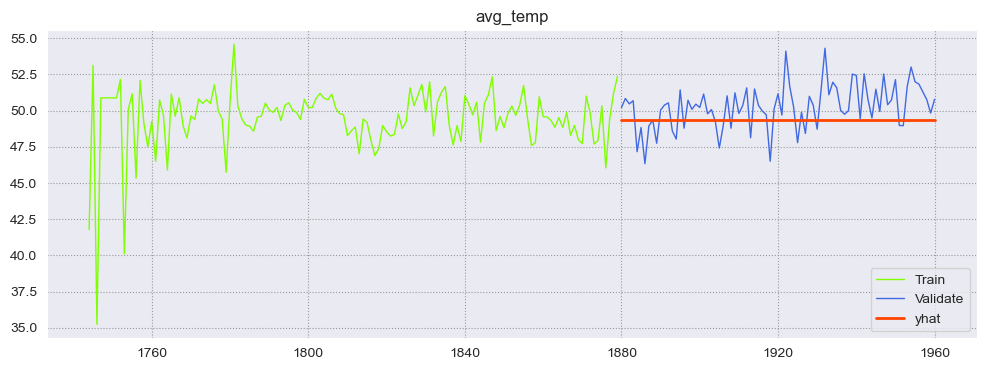

avg_uncert -- RMSE: 1


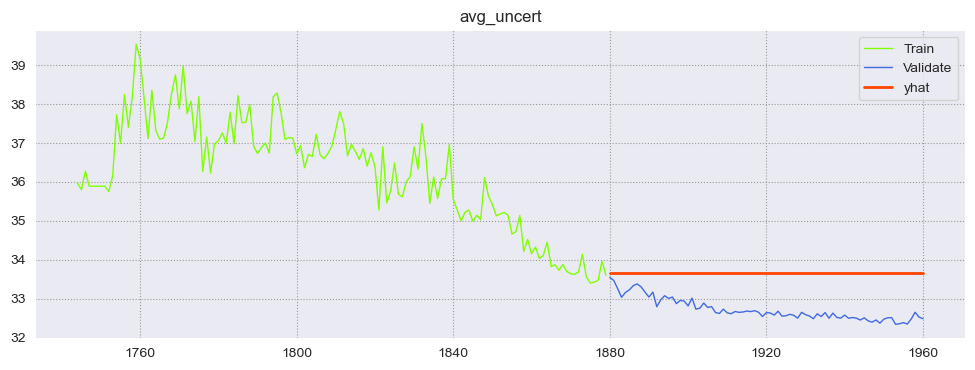

In [63]:
for col in train.columns:
    plot_and_eval(col)

In [64]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,2.592523
1,last_observed_value,avg_uncert,0.927484
2,simple_average,avg_temp,1.720254
3,simple_average,avg_uncert,3.525350
4,30d_moving_avg,avg_temp,1.773999
5,30d_moving_avg,avg_uncert,0.974100


In [82]:
periods = [5, 10, 15, 20]

for p in periods: 
    rolling_temp_avg = train['avg_temp'].rolling(p).mean()[-1]
    rolling_uncert_avg = train['avg_uncert'].rolling(p).mean()[-1]
    yhat_df = make_baseline_predictions(rolling_temp_avg, rolling_uncert_avg)
    model_type = str(p) + '_year_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [83]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,2.592523
1,last_observed_value,avg_uncert,0.927484
2,simple_average,avg_temp,1.720254
3,simple_average,avg_uncert,3.525350
4,30d_moving_avg,avg_temp,1.773999
5,30d_moving_avg,avg_uncert,0.974100
6,5_year_moving_avg,avg_temp,1.569515
7,5_year_moving_avg,avg_uncert,0.897333
8,10_year_moving_avg,avg_temp,1.775934
9,10_year_moving_avg,avg_uncert,0.973612


In [84]:
best_uncert_rmse = eval_df[eval_df.target_var == 'avg_uncert']['rmse'].min()

In [85]:
best_uncert_rmse

0.8973333077431067

In [86]:
eval_df[eval_df.rmse == best_uncert_rmse]


,model_type,target_var,rmse
7,5_year_moving_avg,avg_uncert,0.897333


In [87]:
best_temp_rmse = eval_df[eval_df.target_var == 'avg_temp']['rmse'].min()

eval_df[eval_df.rmse == best_temp_rmse]

,model_type,target_var,rmse
6,5_year_moving_avg,avg_temp,1.569515


In [88]:
chicago_df.head(20)

,avg_temp,avg_uncert,city,country,lat,long
dt,,,,,,
1743-11-01,41.7848,35.9690,Chicago,United States,42.59N,87.27W
1744-04-01,47.7788,36.2426,Chicago,United States,42.59N,87.27W
1744-05-01,52.8890,35.7836,Chicago,United States,42.59N,87.27W
1744-06-01,64.3370,35.5802,Chicago,United States,42.59N,87.27W
1744-07-01,71.0240,35.2148,Chicago,United States,42.59N,87.27W
1744-09-01,62.6540,35.4686,Chicago,United States,42.59N,87.27W
1744-10-01,51.1916,35.8970,Chicago,United States,42.59N,87.27W
1744-11-01,42.3968,35.7494,Chicago,United States,42.59N,87.27W
1744-12-01,32.6678,36.4478,Chicago,United States,42.59N,87.27W


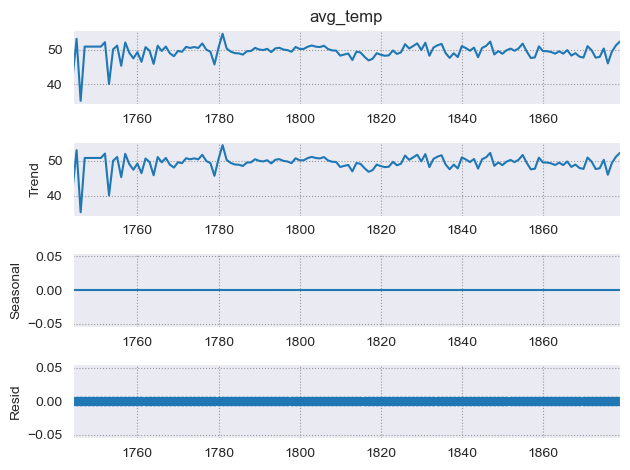

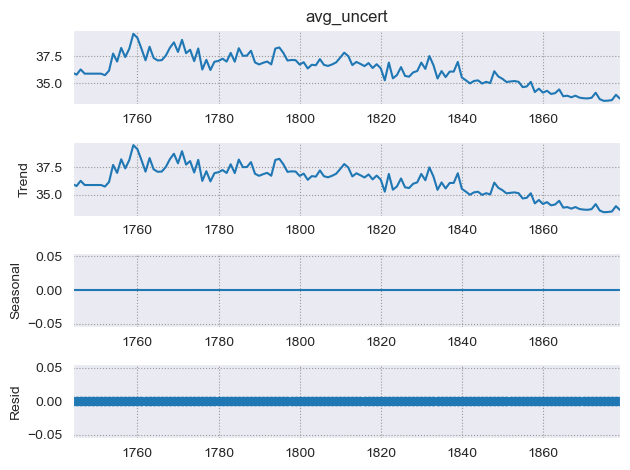

In [89]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('Y').mean()).plot()

In [90]:
col = 'avg_temp' 
model = Holt(train[col], exponential=False, damped=True)

In [91]:
model = model.fit(optimized=True)

In [92]:
yhat_avg_temp = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [93]:
validate.shape

(81, 2)

In [94]:
validate.head()

,avg_temp,avg_uncert
dt,,
1879-12-31,50.20085,33.54350
1880-12-31,50.83310,33.46775
1881-12-31,50.45720,33.25640
1882-12-31,50.67935,33.03410
1883-12-31,47.15795,33.15905


In [95]:
yhat_avg_temp

1879-12-31    49.637686
1880-12-31    49.637686
1881-12-31    49.637686
1882-12-31    49.637686
1883-12-31    49.637686
                ...    
1955-12-31    49.637686
1956-12-31    49.637686
1957-12-31    49.637686
1958-12-31    49.637686
1959-12-31    49.637686
Freq: A-DEC, Length: 81, dtype: float64

In [96]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = yhat_values

In [97]:
yhat_df.head()

,avg_temp,avg_uncert
dt,,
1879-12-31,49.637686,33.661021
1880-12-31,49.637686,33.661026
1881-12-31,49.637686,33.661029
1882-12-31,49.637686,33.661033
1883-12-31,49.637686,33.661036


avg_temp -- RMSE: 2


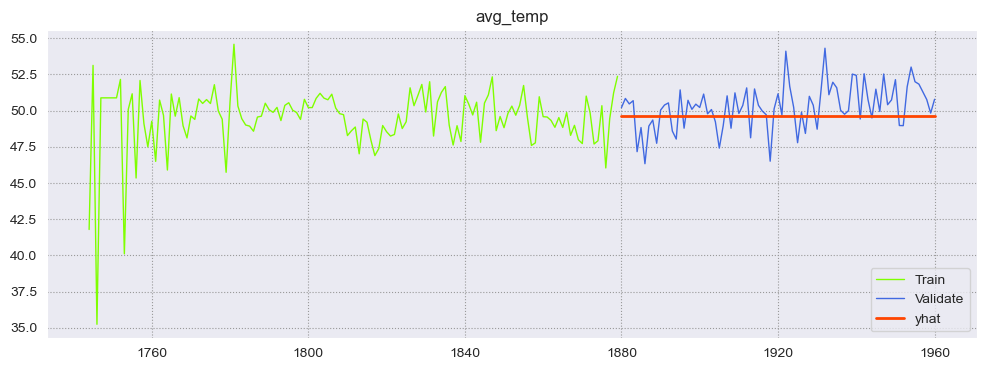

avg_uncert -- RMSE: 1


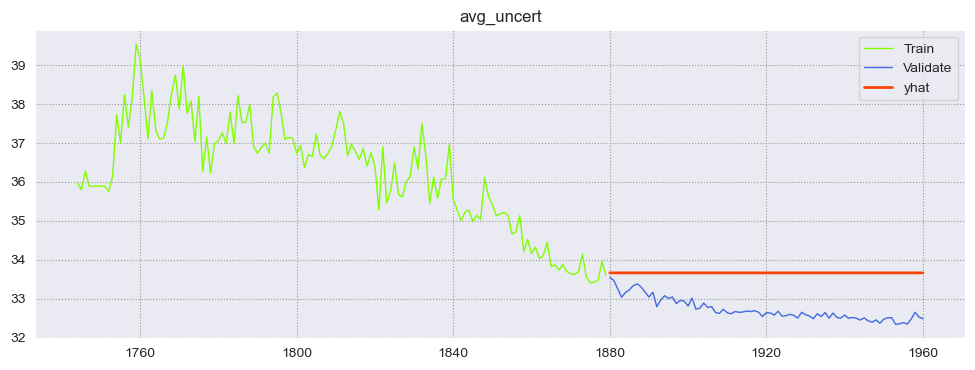

In [98]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [99]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', target_var = col)

In [100]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
7,5_year_moving_avg,avg_uncert,0.897333
15,5_year_moving_avg,avg_uncert,0.898064
1,last_observed_value,avg_uncert,0.927484
9,10_year_moving_avg,avg_uncert,0.973612
17,10_year_moving_avg,avg_uncert,0.974100
5,30d_moving_avg,avg_uncert,0.974100
23,holts_optimized,avg_uncert,0.984214
11,15_year_moving_avg,avg_uncert,1.021575
19,15_year_moving_avg,avg_uncert,1.021720
21,20_year_moving_avg,avg_uncert,1.145444
